In [1]:
import pymc3 as pm
# 定义一个变量模型，后面的所有随机变量都会写入其中
model = pm.Model()

/Users/hui/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/hui/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


(0.0, 74.0)

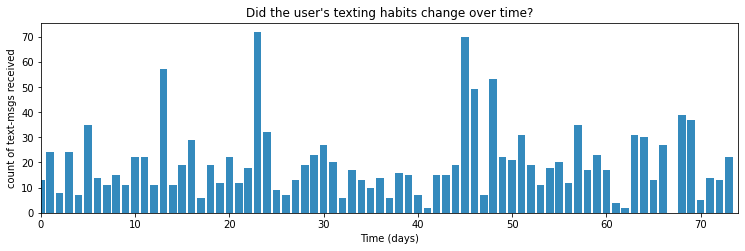

In [3]:
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

count_data = [13., 24.,  8., 24.,  7., 35., 14., 11., 15., 11., 22., 22., 11.,
        57., 11., 19., 29.,  6., 19., 12., 22., 12., 18., 72., 32.,  9.,
         7., 13., 19., 23., 27., 20.,  6., 17., 13., 10., 14.,  6., 16.,
        15.,  7.,  2., 15., 15., 19., 70., 49.,  7., 53., 22., 21., 31.,
        19., 11., 18., 20., 12., 35., 17., 23., 17.,  4.,  2., 31., 30.,
        13., 27.,  0., 39., 37.,  5., 14., 13., 22.]
n_count_data = len(count_data)
n_count_data, count_data
count_data = np.array(count_data)
figsize(12.5, 3.5)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data)

In [4]:
import pymc3 as pm
import theano.tensor as tt
#定义一个变量模型，后面的所有随机变量都会写入其中
model = pm.Model()
with model:#利用with定义一个上下文管理器，以 model 作为上下文。
           #在这个上下文中定义的变量都会被添加到这个模型中去
        
    # α 变量为样本中计算平均值的逆（即倒数的意思）
    alpha = 1.0/count_data.mean()  
    
    #三个 λ的值都服从指数密度函数分布，函数参数为α
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    lambda_3 = pm.Exponential("lambda_3", alpha)
                              
    #τ，即λ发生改变的时间，为 0 -70 中的任意一天(总共71天)
    #因为τ是代表的天数，是离散的，这里通过 DiscreteUniform 设置它为离散型变量
    #即产生随机数
    tau_1 = pm.DiscreteUniform("tau_1", lower=0, upper=n_count_data - 1)
    tau_2 = pm.DiscreteUniform("tau_2", lower=0, upper=n_count_data - 1)
model

In [5]:
with model:
    idx = np.arange(n_count_data) # idf 表示天数
    #lambda_ 表示每天的 λ的值
    #使用where 条件语句去达到 3 分段函数赋值的效果
    lambda_ =  pm.math.where (idx<tau_1,lambda_1, 
                              pm.math.where (idx<tau_2,lambda_2,lambda_3))
type(lambda_)  

theano.tensor.var.TensorVariable

In [7]:
with model:
    # 将统计数据 与 参数为 lambda_ 的 Poisson 分布相结合。
    observation = pm.Poisson("obs", lambda_, observed=count_data)
type(observation)

pymc3.model.ObservedRV

In [8]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(1000, tune=500, step=step)

/Users/hui/anaconda3/lib/python3.7/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau_2]
>Metropolis: [tau_1]
>Metropolis: [lambda_3]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 22 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [9]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
lambda_3_samples = trace['lambda_3']
tau1_samples = trace['tau_1']
tau2_samples = trace['tau_2']
print("lambda1:", lambda_1_samples)
print("lambda2:", lambda_2_samples)
print("lambda3:", lambda_3_samples)
print("tau_1:", tau1_samples)
print("tau_2:", tau2_samples)

lambda1: [20.86084208 20.86084208 20.86084208 ... 18.32244782 18.32244782
 18.32244782]
lambda2: [11.03177151 11.03177151 11.03177151 ... 11.0102182  11.0102182
 11.0102182 ]
lambda3: [21.16632716 21.16632716 21.16632716 ... 21.13384639 21.13384639
 21.13384639]
tau_1: [32 32 32 ... 32 32 32]
tau_2: [44 44 43 ... 43 43 44]


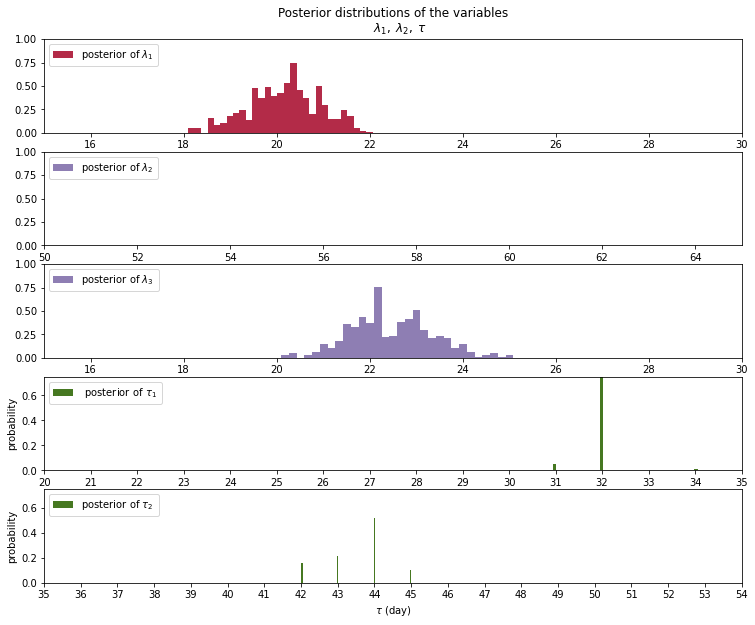

In [11]:

figsize(12.5, 10)
#下面的代码全为图像可视化代码
#将图像分为三份，现在ax代表的是第一行第一张
ax = plt.subplot(511)
ax.set_autoscaley_on(False)
#画出lambda_1 的后验分布
plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

#画出lambda_2 的后验分布
ax = plt.subplot(512)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([50, 65])
plt.xlabel("$\lambda_2$ value")

#画出lambda_3 的后验分布
ax = plt.subplot(513)
ax.set_autoscaley_on(False)
plt.hist(lambda_3_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_3$ ", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

#画出 tau_1 的后验分布
plt.subplot(514)
w = 1.0 / tau1_samples.shape[0] * np.ones_like(tau1_samples)
plt.hist(tau1_samples, bins=n_count_data, alpha=1,
         label=r" posterior of $\tau_1$ ",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([20, 35])
plt.xlabel(r"$\tau$ (day)")
plt.ylabel("probability");

##画出 tau_2 的后验分布
plt.subplot(515)
w = 1.0 / tau2_samples.shape[0] * np.ones_like(tau2_samples)
plt.hist(tau2_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau_2$ ",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (day)")
plt.ylabel("probability");